In [110]:
from drn_interactions.interactions.loaders import SpontaneousActivityLoader
from drn_interactions.interactions.preprocessors import InteractionsPreprocessor
from drn_interactions.interactions.pairwise import PairwiseCorr
from drn_interactions.interactions.graph_clustering import df_to_graph
from drn_interactions.config import Config, ExperimentInfo
import numpy as np
from drn_interactions.interactions.graph import GraphAttributes, NodeAttributes
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from drn_interactions.io import load_derived_generic, load_distances
from drn_interactions.transforms.graph import GraphTransformer
from drn_interactions.transforms.spikes import SpikesHandler
from sklearn.preprocessing import minmax_scale, robust_scale
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.ndimage import gaussian_filter1d

sns.set_theme(style="ticks", context="paper")
fig_dir = Config.fig_dir

In [132]:
def reorder_df_affinity(df, ensemble_labels):
    idx = np.argsort(ensemble_labels)
    return df.iloc[idx, idx]

def reorder_spikes(df, ensemble_labels):
    idx = np.argsort(ensemble_labels)
    return df.iloc[idx, :]


def get_affinity(session_name, t_start=0, t_stop=1800, rectify=True):
    loader = SpontaneousActivityLoader(session_name=session_name, t_start=t_start, t_stop=t_stop)
    preprocessor = InteractionsPreprocessor(z=True)
    mod = PairwiseCorr(rectify=rectify)

    spikes = preprocessor(loader())
    return mod.fit(spikes).get_adjacency_df()

def plot_affinity(df_affinity, ax, vmax=None, **kwargs):
    sns.heatmap(df_affinity, cmap="viridis", vmin=0, vmax=vmax, robust=True, ax=ax, **kwargs)
    return ax

def plot_spikes(spikes, ax, vmax=None, **kwargs):
    sns.heatmap(spikes, cmap="Greys", vmin=0, vmax=vmax, robust=True, ax=ax, **kwargs)
    return ax

def plot_lineplot(spikes, neurons, ax=None, sigma=None, colors=("red", "grey"), **kwargs):
    spikes = spikes.loc[neurons, :]
    if sigma is not None:        
        spikes = spikes.transform(gaussian_filter1d, sigma=sigma, axis=1)
    time = spikes.columns.values
    n1 = spikes.loc[neurons[0], :].values
    n2 = spikes.loc[neurons[1], :].values
    ax.plot(time, n1, label=neurons[0], color=colors[0], **kwargs)
    ax.plot(time, n2, label=neurons[1], color=colors[1], **kwargs)
    return ax

In [133]:
neuron_types = load_derived_generic("neuron_types.csv")
sessions = neuron_types["session_name"].unique()
print(sessions.tolist())

['ESHOCK_03_LOC1', 'ESHOCK_04_LOC1', 'ESHOCK_06_LOC1', 'ESHOCK_07_LOC1', 'ESHOCK_08_LOC1', 'ESHOCK_09_LOC1', 'hamilton_10', 'hamilton_03', 'hamilton_04', 'hamilton_09', 'hamilton_31', 'hamilton_38', nan, 'hamilton_37', 'hamilton_35', 'hamilton_36', 'hamilton_32', 'acute_15', 'acute_16', 'acute_01', 'acute_14', 'acute_12', 'acute_11']


In [134]:
session_name = "acute_11"
# session_name = sessions[13]
ensembles = (
    load_derived_generic("ensembles/spont - ensembles - true.csv")
    .query("session_name == @session_name")
    .sort_values("neuron_id")
)
labels = ensembles["ensemble_id"].values


spikes = SpikesHandler(
    block="pre",
    bin_width=1,
    t_stop=1800,
    session_names=[session_name],
).binned_piv

vals = TfidfTransformer().fit_transform(spikes).todense()
spikes = pd.DataFrame(vals, columns=spikes.columns, index=spikes.index).apply(minmax_scale).T

spikes = reorder_spikes(spikes, labels)

df_affinity = get_affinity(session_name)
df_affinity = reorder_df_affinity(df_affinity, labels)

### Example Rsc

### Example Ensemble

- Line plot of smoothed firing rate

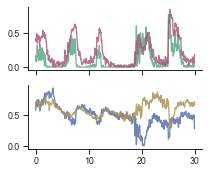

In [135]:
neurons = spikes.index.values
neuron_pair_1 = (neurons[1], neurons[2])
neuron_pair_2 = (neurons[22], neurons[23])

f = plt.figure(figsize=(3, 2.5))
axes = f.subplots(2, 1, sharex=True, sharey=False)

plot_lineplot(
    spikes, 
    neuron_pair_1, 
    ax=axes[0], 
    sigma=2, 
    colors=("#5ba886", "#a85b7d"),
    linewidth=1.3,
    alpha=0.85
)
plot_lineplot(
    spikes, 
    neuron_pair_2, 
    ax=axes[1], 
    sigma=2, 
    colors=("#5b6ea8", "#a8955b"),
    linewidth=1.3,
    alpha=0.85
)

axes[1].set_xticks(np.arange(0, 1801, 600))
axes[1].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: int(x / 60)))
sns.despine(fig=f)
f.tight_layout()

f.savefig(fig_dir / "example correlated pair.png", dpi=300)

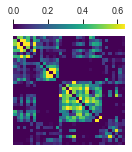

In [136]:
f = plt.figure(figsize=(2, 2.5))

ax = f.subplots()

plot_affinity(df_affinity, ax=ax, cbar_kws = dict(use_gridspec=False,location="top"))
ax.axis("off")

f.savefig(fig_dir / "example ensemble matrix.png", dpi=300)

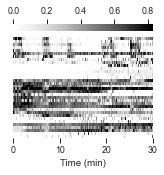

In [149]:
f = plt.figure(figsize=(2.5, 2.3))

ax = f.subplots()

plot_spikes(spikes, ax=ax, cbar_kws = dict(use_gridspec=True,location="top"), yticklabels=[])
ax.set_xticks(np.arange(0, 1801, 600))
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: int(x / 60)))
ax.set_ylabel("")
ax.set_xlabel("Time (min)")

f.savefig(fig_dir / "example ensemble spike heatmap.png", dpi=300)

### Example Ensemble Stability

- Correlation matrix and heatmap

### Interactions By Bin Width

- Point plot v shuffle
- Facet grid by rows
- Rsc, number of ensembles, sequenciness

### Interactions Prediction

- Proportion of neurons in hued by whether they are in an ensemble
- Edge weight predicted by neuron type combination and distance
- Ensemble membership by distance and neuron type combination

### Stability Props

- Node ensemble MI
- Edge correlation